# Congested Scene Recognition - CSRNet

## Understanding the Architecture and Training Method of CSRNet
CSRNet uses VGG-16 as the front end because of its strong transfer learning ability. The output size from VGG is ⅛th of the original input size. CSRNet also uses dilated convolutional layers in the back end.

The basic concept of using dilated convolutions is to enlarge the kernel without increasing the parameters. So, if the dilation rate is 1, we take the kernel and convolve it on the entire image. Whereas, if we increase the dilation rate to 2, the kernel extends as shown in the above image (follow the labels below each image). It can be an alternative to pooling layers.
 
### Underlying Mathematics
I’m going to take a moment to explain how the mathematics work. Note that this isn’t mandatory to implement the algorithm in Python, but I highly recommend learning the underlying idea. This will come in handy when you need to tweak or modify your model.

Suppose we have an input x(m,n), a filter w(i,j), and the dilation rate r. The output y(m,n) will be:

![Dilation Output](images/dilation_output.png)

We can generalize this equation using a (k*k) kernel with a dilation rate r. The kernel enlarges to:

([k + (k-1)*(r-1)] * [k + (k-1)*(r-1)])

So the ground truth has been generated for each image. Each person’s head in a given image is blurred using a Gaussian kernel. All the images are cropped into 9 patches, and the size of each patch is ¼th of the original size of the image. With me so far?

The first 4 patches are divided into 4 quarters and the other 5 patches are randomly cropped. Finally, the mirror of each patch is taken to double the training set.

That, in a nutshell, are the architecture details behind CSRNet. Next, we’ll look at its training details, including the evaluation metric used.

Stochastic Gradient Descent is used to train the CSRNet as an end-to-end structure. During training, the fixed learning rate is set to 1e-6. The loss function is taken to be the Euclidean distance in order to measure the difference between the ground truth and estimated density map. This is represented as:

![Loss function](images/loss_function.png)


where N is the size of the training batch. The evaluation metric used in CSRNet is MAE and MSE, i.e., Mean Absolute Error and Mean Square Error. These are given by:

![MAE and MSE](images/MAE_MSE.png)

Here, Ci is the estimated count:

![Estimated count](images/estimated_count.png)


L and W are the width of the predicted density map.

Our model will first predict the density map for a given image. The pixel value will be 0 if no person is present. A certain pre-defined value will be assigned if that pixel corresponds to a person. So, calculating the total pixel values corresponding to a person will give us the count of people in that image. 

* Paper: https://arxiv.org/abs/1802.10062
* Code: https://github.com/leeyeehoo/CSRNet-pytorch
* Article: https://www.analyticsvidhya.com/blog/2019/02/building-crowd-counting-model-python/

## Code and Dataset
We will implement CSRNet on the ShanghaiTech dataset. This contains 1198 annotated images of a combined total of 330,165 people. You can download the dataset from https://www.dropbox.com/s/fipgjqxl7uj8hd5/ShanghaiTech.zip?dl=0 (166MB). Download this dataset and unzip into a subfolder called _ShanghaiTechDataSet_

Please install CUDA and PyTorch before you proceed further. These are the backbone behind the code we’ll be using below.

We first need to create the ground truth values:

In [2]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
import torchvision.transforms.functional as F
from tqdm import tqdm
%matplotlib inline

In [5]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [6]:
#set the root to the Shanghai dataset you have downloaded
# change the root path as per your location of dataset
root = 'ShanghaiTechDataSet'
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [7]:
# get all images
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

Next we generating the density map for each image. This takes a long time!

In [14]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

ShanghaiTechDataSet\part_A/train_data\images\IMG_1.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_10.jpg
(683, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_100.jpg
(654, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_101.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_102.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_103.jpg
(400, 400)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_104.jpg
(405, 540)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_105.jpg
(632, 990)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_106.jpg
(675, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_107.jpg
(517, 800)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_108.jpg


generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_178.jpg
(688, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_179.jpg
(616, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_18.jpg
(793, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_180.jpg
(386, 509)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_181.jpg
(639, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_182.jpg
(680, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_183.jpg
(687, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_184.jpg
(617, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_185.jpg
(800, 583)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_186.jpg
(653, 460)
generate density...
done.
ShanghaiTechDataSet\part_A/t

ShanghaiTechDataSet\part_A/train_data\images\IMG_63.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_64.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_65.jpg
(683, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_66.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_67.jpg
(683, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_68.jpg
(683, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_69.jpg
(596, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_7.jpg
(590, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_70.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_71.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/train_data\images\IMG_72.jpg
(663,

(683, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_58.jpg
(706, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_59.jpg
(350, 860)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_6.jpg
(687, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_60.jpg
(599, 900)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_61.jpg
(398, 598)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_62.jpg
(480, 624)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_63.jpg
(655, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_64.jpg
(443, 1024)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_65.jpg
(400, 682)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\images\IMG_66.jpg
(1024, 743)
generate density...
done.
ShanghaiTechDataSet\part_A/test_data\i

So far, we have generated the ground truth values for images in part_A. We will do the same for the part_B images. But before that, let’s see a sample image and plot its ground truth heatmap:

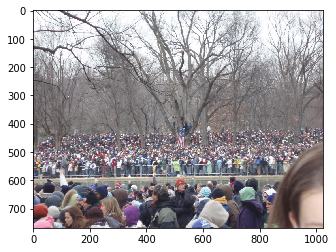

In [15]:
plt.imshow(Image.open(img_paths[0]))

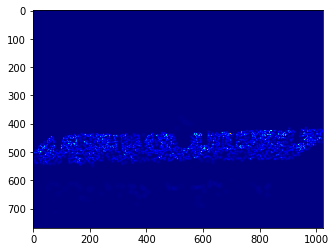

In [16]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

Similarly, we will generate values for part_B:

In [17]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

ShanghaiTechDataSet\part_B/train_data\images\IMG_1.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_10.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_100.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_101.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_102.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_103.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_104.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_105.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_106.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_107.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_108.

ShanghaiTechDataSet\part_B/train_data\images\IMG_254.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_255.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_256.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_257.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_258.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_259.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_26.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_260.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_261.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_262.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_26

ShanghaiTechDataSet\part_B/train_data\images\IMG_49.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_5.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_50.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_51.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_52.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_53.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_54.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_55.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_56.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_57.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/train_data\images\IMG_58.jpg
(768,

ShanghaiTechDataSet\part_B/test_data\images\IMG_205.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_206.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_207.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_208.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_209.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_21.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_210.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_211.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_212.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_213.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_214.jpg
(768,

generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_79.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_8.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_80.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_81.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_82.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_83.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_84.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_85.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_86.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\IMG_87.jpg
(768, 1024)
generate density...
done.
ShanghaiTechDataSet\part_B/test_data\images\I

Now, we have the images as well as their corresponding ground truth values we can train our model!

We will use the .json files available in the cloned directory.  Open a new terminal window and type the following commands:

python train.py part_A_train.json part_A_val.json 0 0

This will take some time. You can reduce the number of epochs in the train.py file to accelerate the process. A cool alternate option is to download the pre-trained weights from here if you don’t feel like waiting.

In [3]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [8]:
path_sets_test = [part_A_test]

In [9]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [12]:
model = CSRNet()
model = model.cuda()
#loading the trained weights
checkpoint = torch.load('ShanghaiTechDataSet/part_A/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

Check the MAE (Mean Absolute Error) on test images to evaluate our model:

In [13]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:30<00:00, 16.02it/s]


62.553354939979144


We get an MAE of 62 which is ok. Look at output for an image

Predicted Count :  384


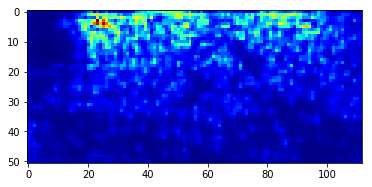

Original Count :  382


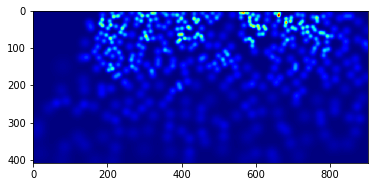

Original Image


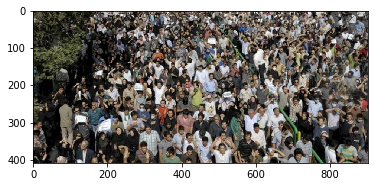

In [15]:
from matplotlib import cm as c
img = transform(Image.open('ShanghaiTechDataSet/part_A/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('ShanghaiTechDataSet/part_A/test_data/ground-truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('ShanghaiTechDataSet/part_A/test_data/images/IMG_100.jpg'))
plt.show()